In [1]:
#Bmore_COVID_EDA_Part3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

zipData = pd.read_csv('ZipData_CLEANED.csv')
zipData = zipData.drop('Unnamed: 0',axis=1)
print(zipData.head())

   Zip Code    AREALAND  AREAWATR  Pop2010    HU100      NHW      NHB   NHAI  \
0     21201   3340677.0       0.0  16972.0  11255.0   5482.0   8896.0   51.0   
1     21202   4111039.0  331316.0  22832.0  10372.0   6049.0  14845.0   48.0   
2     21205   5304530.0       0.0  16146.0   7059.0   2933.0  11259.0   64.0   
3     21206  18667230.0    3869.0  50846.0  21762.0  13133.0  34557.0  167.0   
4     21207  26710727.0   81229.0  48133.0  20272.0   4683.0  40270.0  118.0   

      NHA  NHNH  ...  PCTPOP65  MEDAGE   VACNS  PVACNS  PHOWN  PWOMORT  PRENT  \
0  1519.0   8.0  ...      10.9    30.3  1413.0    12.6    7.8     16.3   90.6   
1   815.0   6.0  ...       6.7    32.3  1972.0    19.0   17.9     21.7   77.2   
2   245.0   5.0  ...      10.1    30.6  1436.0    20.3   23.0     43.8   59.0   
3   784.0  13.0  ...       9.6    35.4  1963.0     9.0   49.5     18.3   39.4   
4   550.0   8.0  ...      13.7    38.7  1494.0     7.4   48.0     19.6   40.2   

   PLT18SP         MHINC  TotalC

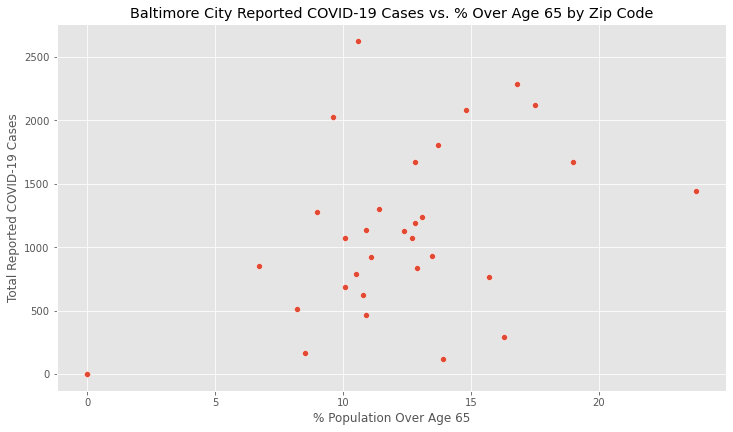

[[1.         0.48676265]
 [0.48676265 1.        ]]


In [2]:
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
_ = sns.scatterplot(x='PCTPOP65',y='TotalCases',data=zipData,legend='brief')
_ = plt.xlabel('% Population Over Age 65')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. % Over Age 65 by Zip Code')
plt.show()

corr = np.corrcoef(zipData[['PCTPOP65','TotalCases']],rowvar=False)
print(corr)

In [3]:
#remove outliers
y = zipData['PCTPOP65']
removed_outliers_65 = y.between(y.quantile(.05), y.quantile(.95))

In [4]:
zipData = zipData[zipData['PCTPOP65'] != removed_outliers_65]

In [5]:
print(zipData['PCTPOP65'].describe())

count    30.000000
mean     12.670000
std       3.556359
min       6.700000
25%      10.525000
50%      12.550000
75%      13.850000
max      23.800000
Name: PCTPOP65, dtype: float64


In [6]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,1)

    return bs_slope_reps, bs_intercept_reps

In [7]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(zipData['PCTPOP65'].to_numpy(),zipData['TotalCases'].to_numpy(),200)

#95% C.I. for regression line slopes
cis95 = np.percentile(bs_slope_reps,[2.5,97.5])
print(cis95)

[  5.14219049 124.86391844]


In [8]:
#linear regression with 200 bootstrap lines 
a,b = np.polyfit(zipData['PCTPOP65'],zipData['TotalCases'],1)
x = np.array([5,25])
y = a * x + b

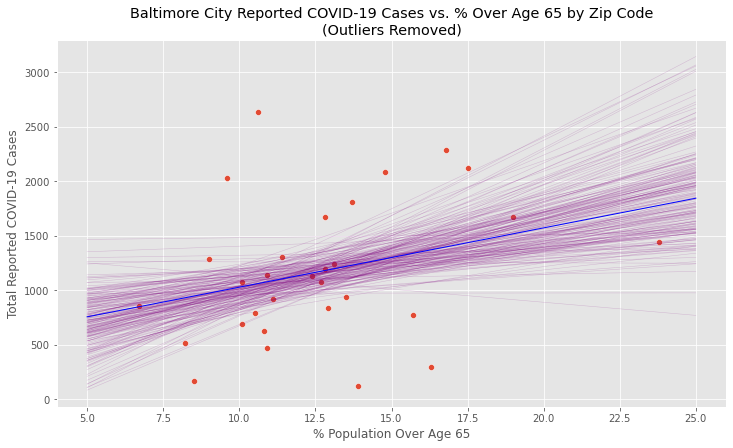

[[1.         0.30259135]
 [0.30259135 1.        ]]


In [9]:
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
for i in range(200):
    _ = plt.plot(x,bs_slope_reps[i]*x + bs_intercept_reps[i],
                linewidth=0.5,alpha=0.2,color='purple')
_ = sns.scatterplot(x='PCTPOP65',y='TotalCases',data=zipData,legend='brief')
_ = plt.plot(x,y,linewidth=1, color='blue')
_ = plt.xlabel('% Population Over Age 65')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. % Over Age 65 by Zip Code\n(Outliers Removed)')
plt.show()

corr = np.corrcoef(zipData[['PCTPOP65','TotalCases']],rowvar=False)
print(corr)

In [10]:
caseArray = zipData['TotalCases'].to_numpy()
per33 = np.percentile(caseArray,100/3)
print(per33)
per67 = np.percentile(caseArray,((100/3)*2))
print(per67)

labelList = []

for index, row in zipData.iterrows():
    if row['TotalCases'] < per33:
        labelList.append('lowCases')
    elif row['TotalCases'] >= per33:
        if row['TotalCases'] < per67:
            labelList.append('medCases')
        elif row['TotalCases'] >= per67:
            labelList.append('highCases')
        
zipData['classLabel'] = labelList
print(zipData[['Zip Code','Pop2010','PCTPOP65','TotalCases','classLabel']])

847.0
1288.6666666666667
    Zip Code  Pop2010  PCTPOP65  TotalCases classLabel
0      21201  16972.0      10.9         468   lowCases
1      21202  22832.0       6.7         851   medCases
2      21205  16146.0      10.1         686   lowCases
3      21206  50846.0       9.6        2029  highCases
4      21207  48133.0      13.7        1804  highCases
5      21208  33917.0      23.8        1443  highCases
6      21209  26465.0      15.7         768   lowCases
7      21210  14292.0      13.9         120   lowCases
8      21211  17351.0      16.3         290   lowCases
9      21212  32322.0      12.9         839   lowCases
10     21213  32733.0      10.9        1140   medCases
11     21214  20564.0      10.8         621   lowCases
12     21215  60161.0      16.8        2287  highCases
13     21216  32071.0      13.5         933   medCases
14     21217  37111.0      11.1         921   medCases
15     21218  49796.0      11.4        1302  highCases
16     21222  55786.0      14.8        2

In [11]:
X_train, X_test, y_train, y_test = \
    train_test_split(zipData[['Pop2010','PCTPOP65']],\
                     zipData['classLabel'],test_size=0.3,\
                         random_state=123,stratify=zipData['classLabel'])

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)
print('\n\nPredictions:')
print(y_pred)
score = knn.score(X_test,y_test)
print('\n\nAccuracy:')
print(score)
print('\n')



Predictions:
['highCases' 'medCases' 'lowCases' 'medCases' 'lowCases' 'highCases'
 'lowCases' 'medCases' 'lowCases']


Accuracy:
0.7777777777777778


